In [0]:
# Google 드라이브를 마운트하려면 이 셀을 실행하세요.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np

In [0]:
!pip install surprise

In [0]:
import os 
os.listdir('./drive/My Drive/colab/recsys/data')


['test.csv',
 'train.csv',
 'item_metadata.csv',
 'submission_popular.csv',
 'reference_first.pkl',
 'dwell_df.csv',
 'df_ref.csv']

In [0]:
path = './drive/My Drive/colab/recsys/data/'

df_ref = pd.read_csv(path + 'df_ref.csv')
df_ref.shape

(1682962, 3)

In [0]:
df_ref.head()

,user_id,reference_int,ref_count
0,0001VQMGUI65,3133074.0,11.0
1,0001VQMGUI65,477811.0,1.0
2,0001VQMGUI65,950829.0,1.0
3,0001VQMGUI65,2019467.0,1.0
4,0001VQMGUI65,4521140.0,1.0


In [0]:
df_ref.ref_count.describe()

count    1.682962e+06
mean     7.870252e+00
std      9.933566e+00
min      1.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      1.200000e+01
max      2.850000e+01
Name: ref_count, dtype: float64

In [0]:
df_ref.ref_count.value_counts()

1.0     640882
28.5    271229
2.0     217104
3.0     140884
4.0      61145
5.0      41599
6.0      30889
7.0      26760
10.0     25710
8.0      25707
9.0      25535
11.0     25180
12.0     24626
13.0     23858
14.0     22990
15.0     21525
16.0     20276
17.0     19164
18.0     17899
Name: ref_count, dtype: int64

In [0]:
df_ref.ref_count.max()

28.5

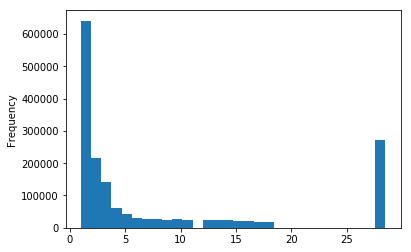

In [0]:
df_ref.ref_count.plot.hist(bins = 30)

https://antilibrary.org/2086

## item별로 선택받은 횟수

In [0]:
byitem = df_ref.groupby('reference_int')['ref_count'].count()

In [0]:
byitem.describe()

count    336412.000000
mean          5.002681
std          11.361160
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max         740.000000
Name: ref_count, dtype: float64

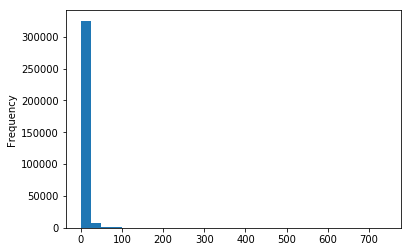

In [0]:
byitem.plot.hist(bins = 30)

In [0]:
np.mean(byitem == 1)

0.45199338905865427

## user별로 선택한 횟수

In [0]:
df_ref.head(3)

,user_id,reference_int,ref_count
0,0001VQMGUI65,3133074.0,11.0
1,0001VQMGUI65,477811.0,1.0
2,0001VQMGUI65,950829.0,1.0


In [0]:
byuser = df_ref.groupby('user_id')['ref_count'].count()
np.mean(byuser == 1)

0.39948842347086694

In [0]:
byuser.describe()

count    544982.000000
mean          3.088106
std           4.070288
min           1.000000
25%           1.000000
50%           2.000000
75%           3.000000
max         359.000000
Name: ref_count, dtype: float64

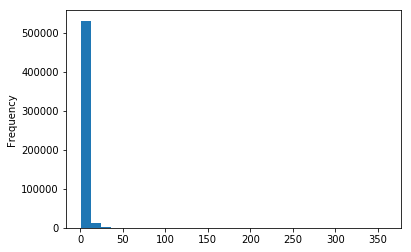

In [0]:
byuser.plot.hist(bins = 30)

## filtering users and items

In [0]:
filter_items = df_ref['reference_int'].value_counts() > 1
filter_items = filter_items[filter_items].index.tolist()

filter_users = df_ref['user_id'].value_counts() > 1
filter_users = filter_users[filter_users].index.tolist()

df_new = df_ref[(df_ref['reference_int'].isin(filter_items)) & (df_ref['user_id'].isin(filter_users))]

print('The original data frame shape : ', df_ref.shape)
print('The new data frame shape : ', df_new.shape)

del df_ref

The original data frame shape :  (1682962, 3)
The new data frame shape :  (1332736, 3)


# Surprise package

In [0]:
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate, train_test_split
from surprise import NormalPredictor
#from surprise import KNNBasic,KNNWithMeans,KNNWithZScore,KNNBaseline #memory error
from surprise import SVD, SVDpp, NMF
from surprise import BaselineOnly, CoClustering
from surprise import NormalPredictor
from surprise.accuracy import rmse
from surprise import accuracy

In [0]:
reader = Reader(rating_scale=(2,28.5))
data = Dataset.load_from_df(df_new[['user_id','reference_int','ref_count']], reader)

In [0]:
benchmark = []

# SVD

In [0]:
print('algorithm : ', 'SVD')
results = cross_validate(SVD(), data, measures=['RMSE'], cv = 3, verbose = False)

#get results
tmp = pd.DataFrame.from_dict(results).mean(axis = 0)
tmp = tmp.append(pd.Series('SVD', index = ['Algorithm']))
benchmark.append(tmp)

algorithm :  SVD


In [0]:
tmp

test_rmse    9.3213
fit_time     77.182
test_time    7.0765
Algorithm       SVD
dtype: object

# SVDpp

In [0]:
print('algorithm : ', 'SVDpp')
results = cross_validate(SVDpp(), data, measures=['RMSE'], cv = 3, verbose = False)

#get results
tmp = pd.DataFrame.from_dict(results).mean(axis = 0)
tmp = tmp.append(pd.Series('SVDpp', index = ['Algorithm']))
benchmark.append(tmp)

algorithm :  SVDpp


In [0]:
tmp

test_rmse    9.67288
fit_time     199.856
test_time    15.3761
Algorithm        SVD
dtype: object

# NMF

In [0]:
print('algorithm : ', 'NMF')
results = cross_validate(NMF(), data, measures=['RMSE'], cv = 3, verbose = False)

#get results
tmp = pd.DataFrame.from_dict(results).mean(axis = 0)
tmp = tmp.append(pd.Series('NMF', index = ['Algorithm']))
benchmark.append(tmp)
tmp

algorithm :  NMF


test_rmse    9.97242
fit_time     136.315
test_time    6.48009
Algorithm        NMF
dtype: object

# BaselineOnly

In [0]:
print('algorithm : ', 'BaselineOnly')
results = cross_validate(BaselineOnly(), data, measures=['RMSE'], cv = 3, verbose = False)

#get results
tmp = pd.DataFrame.from_dict(results).mean(axis = 0)
tmp = tmp.append(pd.Series('BaselineOnly', index = ['Algorithm']))
benchmark.append(tmp)
tmp

algorithm :  BaselineOnly
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


test_rmse         9.32758
fit_time          7.83443
test_time         5.88081
Algorithm    BaselineOnly
dtype: object

# Co clustering

In [0]:
print('algorithm : ', 'CoClustering')
results = cross_validate(CoClustering(), data, measures=['RMSE'], cv = 3, verbose = False)

#get results
tmp = pd.DataFrame.from_dict(results).mean(axis = 0)
tmp = tmp.append(pd.Series('CoClustering', index = ['Algorithm']))
benchmark.append(tmp)
tmp

algorithm :  CoClustering


test_rmse         9.61101
fit_time          76.7366
test_time          5.6426
Algorithm    CoClustering
dtype: object

# NormalPredictor

In [0]:
print('algorithm : ', 'NormalPredictor')
results = cross_validate(NormalPredictor(), data, measures=['RMSE'], cv = 3, verbose = False)

#get results
tmp = pd.DataFrame.from_dict(results).mean(axis = 0)
tmp = tmp.append(pd.Series('NormalPredictor', index = ['Algorithm']))
benchmark.append(tmp)
tmp

algorithm :  NormalPredictor


test_rmse            13.0077
fit_time              2.4279
test_time            5.80882
Algorithm    NormalPredictor
dtype: object

### SVD, BaselineOnly best!!

# Train and Predict

## BaselineOnly

In [0]:
print('Using ALS')
bsl_options = {'method' : 'als',
              'n_epochs' : 5,
              'reg_u' : 12,
              'reg_i' : 5}

algo = BaselineOnly(bsl_options=bsl_options)
cross_validate(algo, data, measures=['RMSE'], cv = 3, verbose=False)

Using ALS
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


{'fit_time': (4.370826005935669, 4.798277139663696, 4.7866010665893555),
 'test_rmse': array([9.24898479, 9.27478004, 9.26986095]),
 'test_time': (6.4433910846710205, 6.268344163894653, 6.2631213665008545)}

In [0]:
trainset,testset = train_test_split(data, test_size = 0.3)
algo = BaselineOnly(bsl_options=bsl_options)
pred = algo.fit(trainset).test(testset)
accuracy.rmse(pred)

Estimating biases using als...
RMSE: 9.2211


9.221136041191842

In [0]:
testset

[('8JV2SHGWPL1R', 10457146.0, 1.0),
 ('FX4LB67D38JP', 316791.0, 11.0),
 ('YFST3ZR745AS', 6274082.0, 1.0),
 ('DPCZOKVWIB00', 1724665.0, 1.0),
 ('2GN74YCWIC3E', 43750.0, 13.0),
 ('S3YIWZ794WSD', 2767204.0, 6.0),
 ('HI7DC0VA08M9', 1034502.0, 28.5),
 ('9E1997L1OHY8', 41171.0, 1.0),
 ('T47075JIUABU', 758131.0, 6.0),
 ('SYSJZWT8GJWO', 1392988.0, 15.0),
 ('ZVWM10NXW7RT', 3381230.0, 1.0),
 ('OLXE27LRGMEI', 1334115.0, 1.0),
 ('620XOUOS5D90', 350786.0, 1.0),
 ('GHFI5J3019V5', 164658.0, 28.5),
 ('ZBN44NZCWLIA', 3500898.0, 3.0),
 ('985D7GY5SQQI', 2942001.0, 1.0),
 ('W765TNA0HF7U', 12657.0, 1.0),
 ('X9UQV6WU4KTS', 1266491.0, 18.0),
 ('IF1WS29M1FQZ', 23753.0, 1.0),
 ('CLIHP8EKZ32J', 444846.0, 16.0),
 ('RM9PBSD7CMP5', 1247493.0, 2.0),
 ('X7K972WUNLL3', 76837.0, 17.0),
 ('7QE8DMK6ZN38', 1242485.0, 1.0),
 ('RU1X6ZKQIVUM', 103475.0, 1.0),
 ('XTA58N41IR1A', 53835.0, 15.0),
 ('ANCW963W4J58', 149587.0, 2.0),
 ('S98STRAJX3Y1', 9720006.0, 28.5),
 ('3KKBWMMEJ4JP', 47712.0, 4.0),
 ('KA27P8Q5W785', 2042385.0, 1

In [0]:
def get_Iu(uid) :
  try :
    return len(trainset.ur[trainset.to_inner_uid(uid)])
  except ValueError :
    return 0
  
def get_Ui(iid) :
  try :
    return len(trainset.ir[trainset.to_inner_iid(iid)])
  except ValueError :
    return 0

In [0]:
df = pd.DataFrame(pred, columns = ['uid','iid','rui','est','details'])
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)

In [0]:
df.shape

(399821, 8)

In [0]:
df.sort_values(by = 'err', inplace = True)
df.head()

,uid,iid,rui,est,details,Iu,Ui,err
228650,16P4IKHQOFH9,49533.0,2.0,2.0,{'was_impossible': False},43,26,0.0
208356,UOXKVF8WID52,9764036.0,2.0,2.0,{'was_impossible': False},7,56,0.0
8086,M0CRX7B4YN93,4949748.0,2.0,2.0,{'was_impossible': False},1,77,0.0
50483,O0KGLPMF98Q8,1460411.0,2.0,2.0,{'was_impossible': False},33,16,0.0
202672,50YD0I82D9QO,3992988.0,2.0,2.0,{'was_impossible': False},2,22,0.0


In [0]:
df.tail(10)

,uid,iid,rui,est,details,Iu,Ui,err
213281,LB7W0UXL76OP,1244912.0,28.5,2.024048,{'was_impossible': False},2,84,26.475952
154033,06DNN6G3DH9Q,342731.0,28.5,2.000000,{'was_impossible': False},2,36,26.500000
341526,99CKCFZ3H69W,478491.0,28.5,2.000000,{'was_impossible': False},12,8,26.500000
137008,737CBO2FXH5O,5737714.0,28.5,2.000000,{'was_impossible': False},12,5,26.500000
73519,X3D1A9DUJXBJ,99422.0,28.5,2.000000,{'was_impossible': False},11,19,26.500000
258898,3RODJWVUCFKZ,10487598.0,28.5,2.000000,{'was_impossible': False},17,5,26.500000
182853,PHN9Z4X90VND,2156040.0,28.5,2.000000,{'was_impossible': False},11,6,26.500000
127441,C2HIHX3P77D6,149591.0,28.5,2.000000,{'was_impossible': False},119,22,26.500000
106925,YKNINOH9QI3U,61700.0,28.5,2.000000,{'was_impossible': False},29,153,26.500000
117147,OVZDADERPF8D,10357418.0,28.5,2.000000,{'was_impossible': False},16,5,26.500000


In [0]:
import matplotlib.pyplot as plt

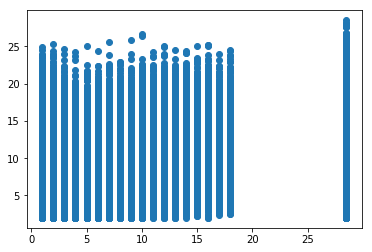

In [0]:
plt.scatter(df.rui, df.est)

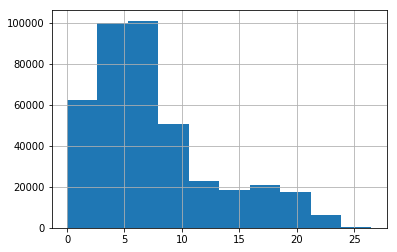

In [0]:
df.err.hist()

In [0]:
df_new.loc[df_new['reference_int'] == 2156040.0]['ref_count'].describe()

count    12.000000
mean      6.000000
std      10.537811
min       1.000000
25%       1.000000
50%       1.000000
75%       3.000000
max      28.500000
Name: ref_count, dtype: float64

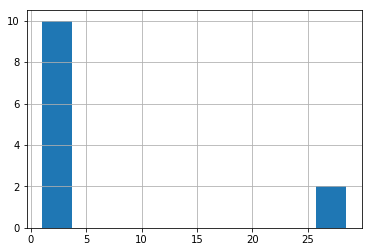

In [0]:
df_new.loc[df_new['reference_int'] == 2156040.0]['ref_count'].hist()